# *dandelion* Notebook-2
![dandelion_logo](img/dandelion_logo.png)

## Filtering
We now move on to filtering out BCR contigs (and corresponding cells if necessary) from the BCR data and transcriptome object loaded in *scanpy*.

#### Import *dandelion* module

In [1]:
import os
os.chdir(os.path.expanduser('/Users/kt16/Documents/Github/dandelion'))
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))

#### Import modules for use with scanpy

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata

warnings.filterwarnings('ignore')
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.3 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


#### Import the transcriptome data

In [3]:
samples = ['sc5p_v2_hs_PBMC_1k', 'sc5p_v2_hs_PBMC_10k', 'vdj_v1_hs_pbmc3', 'vdj_nextgem_hs_pbmc3']
adata_list = []
for sample in samples:
    adata = sc.read_10x_h5(sample +'/' + sample + '_filtered_feature_bc_matrix.h5', gex_only=True)
    adata.obs['sampleid'] = sample
    # rename cells to sample id + barcode
    adata.obs_names = [str(sample)+'_'+str(j) for j in adata.obs_names]
    adata.var_names_make_unique()
    adata_list.append(adata)
adata = adata_list[0].concatenate(adata_list[1:])
# rename the obs_names again, this time cleaving the trailing -#
adata.obs_names = [str(j).split('-')[0] for j in adata.obs_names]
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 30471 × 31915
    obs: 'sampleid', 'batch'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3'

### *pp.recipe_scanpy_qc*
I've included a wrapper called `pp.recipe_scanpy_qc` to run through a generic [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) workflow that includes [scrublet](https://github.com/AllonKleinLab/scrublet) doublet detection. The function does not filter the cells and is simply a way to mark bad quality cells and potential doublets in the `.obs` slot. The scrublet doublet detection is implemented based on [kp9](kp9@sanger.ac.uk)'s *Bertie's* doublet calling [procedure](https://www.nature.com/articles/s41467-018-06318-7).

Whether or not you run this is up to you. You can provide in a pre-processed `AnnData` object for the subsequent steps

In [4]:
ddl.pp.recipe_scanpy_qc(adata)
adata

AnnData object with n_obs × n_vars = 30471 × 31915
    obs: 'sampleid', 'batch', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'scrublet_score_bh_pval', 'is_doublet', 'filter_rna'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3'

As mentioned, the function doesn't actually filter any cells, but just populate the `.obs` slot with the following columns:
```
'n_genes'
'percent_mito'
'n_counts'
'scrublet_score_bh_pval'
'is_doublet'
'filter_rna'
```
Only `'filter_rna'` is needed for the next step.

If you have a pre-processed/filltered `AnnData` object that is ready, just add a `'filter_rna'` column into the `.obs` slot with every value set to `False` and you should be good to go:

```python
adata.obs['filter_rna'] = False
```

In [5]:
# adata.obs['filter_rna'] = False

### *pp.filter_bcr*
#### Filter cells that are potental doublets and poor quality in both the BCR data and transcriptome data
We use the function `pp.filter_bcr` to mark and filter out cells and contigs from both the BCR data and transcriptome data in `AnnData`. The operation will remove bad quality cells based on transcriptome information as well as remove BCR doublets (multiplet heavy chain, and/or light chains) from the BCR data. In some situations, a single cell can have multiple heavy/light chain contigs although they have an identical V(D)J+C alignment; in situations like this, the contigs with lesser umis will be dropped and the umis transferred to duplicate_count column. The same procedure is applied to both heavy chain and light chains before identifying doublets. 

Cells in the gene expression object without BCR information will not be affected i.e. the `AnnData` object can hold non-B cells. Run `?ddl.pp.filter_bcr` to check what each option does.

In [6]:
# first we read in the 4 bcr files
bcr_files = []
for sample in samples:
    file_location = sample +'/dandelion/data/'+sample+'_b_filtered_contig_igblast_db-pass_genotyped.tsv'
    bcr_files.append(pd.read_csv(file_location, sep = '\t'))
bcr = bcr_files[0].append(bcr_files[1:])
bcr.reset_index(inplace = True, drop = True)
bcr

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,c_sequence_start,c_sequence_end,c_score,c_identity,c_support,c_call_10x,sample_id,v_call_genotyped,germline_alignment_d_mask,mu_freq
0,sc5p_v2_hs_PBMC_1k_AACTCCCAGGCTAGGT_contig_1,ACTGCGGGGGTAAGAGGTTGTGTCCACCATGGCCTGGACTCCTCTC...,F,T,IGLV5-45*03,NaN,IGLJ3*02,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTG...,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTG...,TGTATGATTTGGCACAGCAGCGCTTGGGTGTTC,...,431.0,642.0,392.610,100.0,1.000000e-111,IGLC2,sc5p_v2_hs_PBMC_1k,IGLV5-45*03,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTG...,0.000000
1,sc5p_v2_hs_PBMC_1k_AACTCCCAGGCTAGGT_contig_2,ATACTTTCTGAGAGTCCTGGACCTCCTGTGCAAGAACATGAAACAT...,F,T,IGHV4-61*02,IGHD3-3*01,IGHJ6*02,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTT...,TGTGCGAGAGAAAATTACGATTTTTGGAGTGGTTATTACCACGGTG...,...,470.0,541.0,134.079,100.0,7.000000e-34,IGHM,sc5p_v2_hs_PBMC_1k,IGHV4-61*02,NaN,0.000000
2,sc5p_v2_hs_PBMC_1k_AACTCCCAGGCTAGGT_contig_3,GGCTGGGGTCTCAGGAGGCAGCGCTCTGGGGACGTCTCCACCATGG...,F,F,IGLV2-5*01,NaN,IGLJ3*02,CAGTCTGCCCTGATTCAGCCTCCCTCC...GTGTCCGGGTCTCCTG...,CAGTCTGCCCTGATTCAGCCTCCCTCC...GTGTCCGGGTCTCCTG...,TGCTGCTCATATACAAGCAGTGCCACTTTCTTGGGTGTTC,...,433.0,644.0,392.610,100.0,1.000000e-111,IGLC3,sc5p_v2_hs_PBMC_1k,IGLV2-5*01,CAGTCTGCCCTGATTCAGCCTCCCTCC...GTGTCCGGGTCTCCTG...,0.000000
3,sc5p_v2_hs_PBMC_1k_AACTCTTGTCATCGGC_contig_1,AGAGCTCTGGGGAGTCTGCACCATGGCTTGGACCCCACTCCTCTTC...,F,T,IGLV4-69*01,NaN,IGLJ1*01,CAGCTTGTGCTGACTCAATCGCCCTCT...GCCTCTGCCTCCCTGG...,CAGCTTGTGCTGACTCAATCGCCCTCT...GCCTCTGCCTCCCTGG...,TGTCAGACCTGGGGCACTGGCATTTATGTCTTC,...,416.0,627.0,392.610,100.0,1.000000e-111,IGLC1,sc5p_v2_hs_PBMC_1k,IGLV4-69*01,CAGCTTGTGCTGACTCAATCGCCCTCT...GCCTCTGCCTCCCTGG...,0.000000
4,sc5p_v2_hs_PBMC_1k_AACTCTTGTCATCGGC_contig_2,AGCTCTGAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCAC...,F,T,IGHV3-21*01,IGHD3-22*01,IGHJ4*02,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,TGTGCGAGACGTTACTATGATAGTAGTGGTTATTCCGCAAACTTTG...,...,506.0,577.0,134.079,100.0,7.000000e-34,IGHM,sc5p_v2_hs_PBMC_1k,IGHV3-21*01,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7507,vdj_nextgem_hs_pbmc3_TGCCCATTCCAGAGGA_contig_1,AGCTCTGAGAGAGGAGCCCAGCCCTGGGATTTTCAGGTGTTTTCAT...,F,T,"IGHV3-23*01,IGHV3-23D*01",IGHD3-16*02,IGHJ4*02,GAGGTGCAGCTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,GAGGTGCAGCTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,TGTGCGAAAGCCCGCCCGGAGGGAAAGAAGTTATCATTGTTTAGAG...,...,533.0,604.0,134.079,100.0,7.000000e-34,IGHM,vdj_nextgem_hs_pbmc3,"IGHV3-23*01,IGHV3-23D*01",NaN,0.000000
7508,vdj_nextgem_hs_pbmc3_TGCCCATTCCAGAGGA_contig_2,AGCTTCAGCTGTGGGTAGAGAAGACAGGACTCAGGACAATCTCCAG...,F,T,IGLV1-44*01,NaN,"IGLJ2*01,IGLJ3*01",CAGTCTGTGCTGACTCAGCCACCCTCA...GCGTCTGGGACCCCCG...,CAGTCTGTGCTGACTCAGCCACCCTCA...GCGTCTGGGACCCCCG...,TGTGCAGCATGGGATGACAGCCTTTTATTC,...,426.0,637.0,392.610,100.0,1.000000e-111,IGLC2,vdj_nextgem_hs_pbmc3,IGLV1-44*01,CAGTCTGTGCTGACTCAGCCACCCTCA...GCGTCTGGGACCCCCG...,0.000000
7509,vdj_nextgem_hs_pbmc3_TGGCCAGCAACAACCT_contig_1,GATCAGGACTTCTCAGTTCATCTTCTCACCATGAGGCTCCCTGCTC...,F,T,IGKV2D-29*01,NaN,IGKJ4*01,..TATTGTGATGACCCAGACTCCAGTCTCTCTGTCCGTCACCCCTG...,GATATTGTGATGACCCAGACTCCACTCTCTCTGTCCGTCACCCCTG...,TGCAAGCAAAGTATACAGTTTCCGCTCACTTTC,...,427.0,563.0,254.111,100.0,5.000000e-70,IGKC,vdj_nextgem_hs_pbmc3,IGKV2D-29*01,GATATTGTGATGACCCAGACTCCACTCTCTCTGTCCGTCACCCCTG...,0.014970
7510,vdj_nextgem_hs_pbmc3_TGGCGCAGTGTTGGGA_contig_1,TGGGGGACTCCTGTGCCCCACCATGGACACACTTTGCTACACACTC...,F,T,IGHV2-26*01,IGHD3-22*01,IGHJ4*02,CAGGTCACCTTGAAGGAGTCTGGTCCT...GTGCTGGTGAAACCCA...,CAGGTCACCTTGAAGGAGTCTGGTCCT...GTGCTGGTGAAACCCA...,TGTGCACGGATAAGCTTTGATAATAGTGCCTTTGACTACTGG,...,440.0,511.0,134.079,100.0,6.000000e-34,IGHM,vdj_nextgem_hs_pbmc3,IGHV2-26*01,NaN,0.000000


In [7]:
# The function will return both objects. 
vdj, adata = ddl.pp.filter_bcr(bcr, adata)

Marking barcodes with poor quality barcodes and multiplets with 3 cpus


Annotating in anndata obs slot : 100%|██████████| 30471/30471 [00:00<00:00, 74513.96it/s]


Finishing up filtering
Initializing Dandelion object


The default mode is to filter any remaining 'doublet' light chains, but some may be interested in keeping them. The option to change the behaviour is by toggling:
```python
filter_lightchains=False
```

Another default behavour is that if the cell in the BCR table cannot be found in the transcriptomic data, it will also be removed from the BCR data. This can be changed by toggling:
```python
filter_missing=False
```

Also, when contig are marked as poor quality, the default behaviour is to remove the contigs associated with the barcode, and not the barcode from the transcriptome data. This can be toggled to remove the entire cell if the intention is to retain a conservative dataset for both BCR and transcriptome data:
```python
filter_poorqualitybcr=True
```

And lastly, the default behaviour is to rescue the heavy chain contig with the highest umi if there are multiple contigs for a single cell. The function requires a minimum fold-difference of 2 between the highest and lowest umi in order to rescue the contig. However, if the contigs have similar number of umis, or if the sum of the umis are very low, then the entire cell will be filtered. The fold-difference cut-off can be specified via the option `umi_foldchange_cutoff`. This can be toggled to be ignore i.e. drop all multiple IGH contigs:
```python
rescue_igh = False
```

#### Check the output V(D)J table
The vdj table is returned as a `Dandelion` class object in the `.data` slot (described in further detail in the next notebook); if a file was provided for `filter_bcr` above, a new file will be created in the same folder with the `filtered` prefix. Note that this `vdj` table is indexed based on contigs (sequence_id).

In [8]:
vdj

Dandelion class object with n_obs = 837 and n_contigs = 1698
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'cdr1_aa', 'cdr1_end', 'cdr1_start', 'cdr2_aa', 'cdr2_end', 'cdr2_start', 'cdr3_aa', 'cdr3_end', 'cdr3_start', 'd_alignment_end',

#### Check the AnnData object as well
And the `AnnData` object is indexed based on cells.

In [9]:
adata

View of AnnData object with n_obs × n_vars = 16450 × 31915
    obs: 'sampleid', 'batch', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'scrublet_score_bh_pval', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'filter_bcr'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3'

The `AnnData` object now contain a few new columns related to BCR:

1) **`has_bcr` :** `True/False` statement marking cells with a matching BCR (pre-contig filtering).

2) **`filter_bcr_quality` :** `True/False` recommendation for filtering cells identified as having poor quality contigs if `filter_poorqualitybcr=True` (pre-contig filtering).

3) **`filter_bcr_heavy` :** `True/False` recommendation for filtering cells identified as heavy chain 'doublets' (after rescue if `rescue_igh=True`) (pre-contig filtering).

4) **`filter_bcr_light` :** `True/False`recommendation for filtering cells identifed as having multiple light chain contigs (pre-contig filtering).

##### Most importantly:
5) **`filter_bcr` :** `True/False` recommendation for filter for cells flagged in 2-4 (post-contig filtering).

So this means that to go forward, you want to only select cells that have BCR (`has_bcr == True`) and bcr filtering recommendation to be false (`filter_bcr == False`)

#### The number of cells that actually has a matching BCR can be tabluated.

In [10]:
pd.crosstab(adata.obs['has_bcr'], adata.obs['filter_bcr'])

filter_bcr,False
has_bcr,
False,15561
True,889


#### Now actually filter the AnnData object and run through a standard workflow starting by filtering genes and normalizing the data
Because the 'filtered' `AnnData` object was returned as a filtered but otherwise unprocessed object, we still need to normalize and run through the usual process here.

In [11]:
# filter genes
sc.pp.filter_genes(adata, min_cells=3)
# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Stash the normalised counts
adata.raw = adata

Trying to set attribute `.var` of view, copying.


#### Identify highly-variable genes

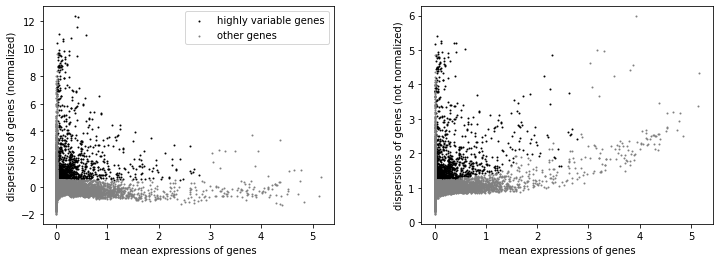

In [12]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

#### Filter the genes to only those marked as highly-variable

In [13]:
adata = adata[:, adata.var.highly_variable]

#### Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.Scale the data to unit variance.

In [14]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

Trying to set attribute `.obs` of view, copying.
... storing 'sampleid' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


#### Run PCA

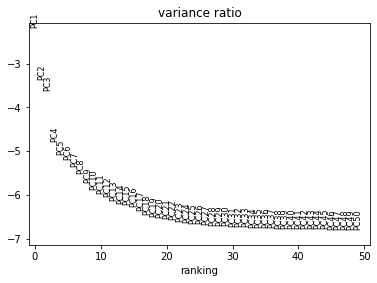

In [15]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

#### Computing the neighborhood graph, umap and clusters

In [16]:
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# Embedding the neighborhood graph
sc.tl.umap(adata)
# Clustering the neighborhood graph
sc.tl.leiden(adata)

#### Visualizing the clusters and whether or not there's a corresponding BCR

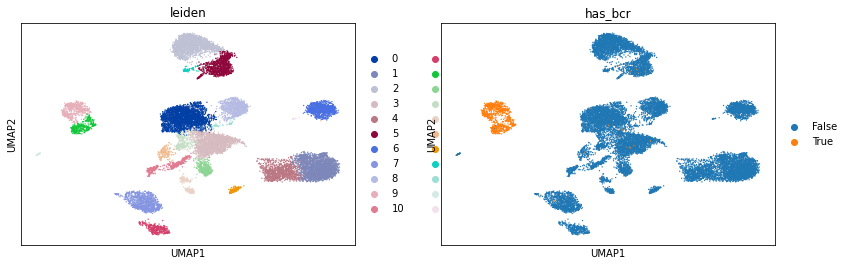

In [17]:
sc.pl.umap(adata, color=['leiden', 'has_bcr'])

#### Visualizing some B cell genes

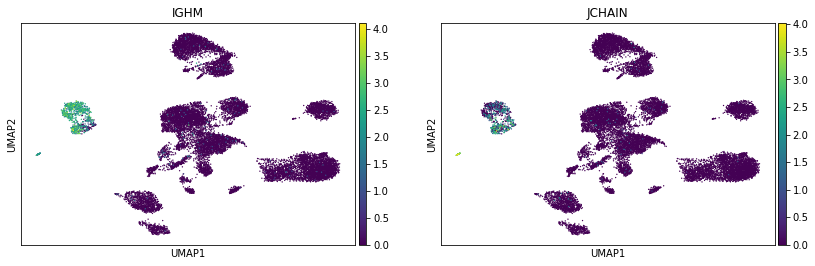

In [18]:
sc.pl.umap(adata, color=['IGHM', 'JCHAIN'])

#### Save the AnnData file
We can save this `AnnData` object for now.

In [19]:
adata.write('adata.h5ad', compression = 'gzip')

... storing 'feature_types' as categorical
... storing 'genome' as categorical


To save the vdj object, we have two options - either save the `.data` and `.metadata` slots with pandas' functions:

In [20]:
vdj.data.to_csv('filtered_vdj_table.tsv', sep = '\t')

Or save the whole Dandelion class object with either `.write_h5`, which saves the class to a HDF5 format, or using a pickle-based `.write_pkl` function.

In [21]:
vdj.write_h5('dandelion_results.h5', complib = 'bzip2')

In [22]:
vdj.write_pkl('dandelion_results.pkl.pbz2') # this will automatically use bzip2 for compression, swith the extension to .gz for gzip